# Create simulated dataset

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pyem import star
import pandas as pd
import mrcfile
import pickle

from simplecryoem.emfiles import load_data
from simplecryoem.forwardmodel import Slice
from simplecryoem.utils import (
    volume_fourier,
    mip_z,
    rescale_larger_grid,
    crop_fourier_images,
    crop_fourier_volume,
    generate_uniform_orientations,
)

In [2]:
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 6, 6

In [22]:
save_to_file = False

In [4]:
# Dirs and file locations

out_dir = "../../simplecryoem_output/out_dev_new/simulated_dataset/"

# Relion data
# refine3dfile = "../../../daniel/RELION_TUTORIAL_SET/PrecalculatedResults/Refine3D/job019/run_class001.mrc"
# data_dir = "../../../daniel/RELION_TUTORIAL_SET/PrecalculatedResults/"
# star_file = "/Extract/job018/particles.star"

# Cryodrgn data
# refine3dfile = "../../../daniel/CrossValidationCryodrgnSet/Refine3D/crossvalidation1/run_class001.mrc"
# data_dir = "../../../daniel/CrossValidationCryodrgnSet/Refine3D/crossvalidation1/"
# star_file = "/run_it000_data.star"

In [ ]:
# Read the volume and the parameters from the star file

vol_r = mrcfile.open(refine3dfile).data

params, _ = load_data(data_dir, star_file, load_imgs=False, fourier=False)

ctf_params = params["ctf_params"]
pixel_size = params["pixel_size"]
angles = params["angles"]
shifts = params["shifts"]
nx = vol_r.shape[0]

print(f"vol_r.shape = {vol_r.shape}")

In [6]:
# Take FFT of volume

vol_f, grid, _ = volume_fourier(vol_r, pixel_size[0])

Text(0.5, 1.0, 'Fourier space')

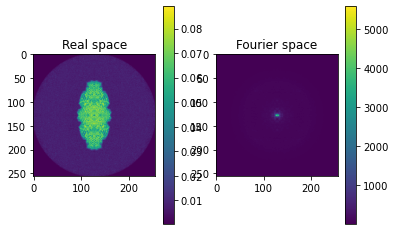

In [7]:
plt.subplot(1, 2, 1)
mip_z(vol_r)
plt.colorbar()
plt.title("Real space")

plt.subplot(1, 2, 2)
mip_z(np.abs(np.fft.fftshift(vol_f)))
plt.colorbar()
plt.title("Fourier space")

In [8]:
# Save the vol
if save_to_file:
    with mrcfile.new(f"{out_dir}/vol2_{nx}.mrc", overwrite=True) as mrc:
        mrc.set_data(vol_r.astype(np.float32))

#### Downsample the volume 

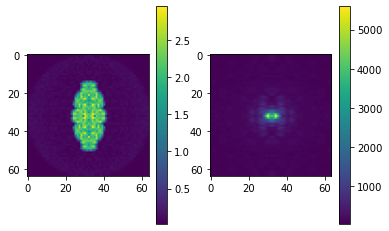

In [9]:
# First, crop to 64px

nx1 = 64

vol_fc, grid_c = crop_fourier_volume(vol_f, grid, nx1)
vol_rc = np.real(np.fft.fftshift(np.fft.ifftn(vol_fc)))

plt.subplot(1, 2, 1)
mip_z(vol_rc)
plt.colorbar()

plt.subplot(1, 2, 2)
mip_z(np.abs(np.fft.fftshift(vol_fc)))
plt.colorbar()

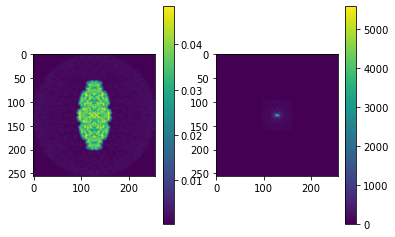

In [10]:
# Obtain the nx0 size volume

vol_fc0, _ = rescale_larger_grid(vol_fc, grid_c, nx)
vol_rc0 = np.real(np.fft.fftshift(np.fft.ifftn(vol_fc0)))

plt.subplot(1, 2, 1)
mip_z(vol_rc0)
plt.colorbar()

plt.subplot(1, 2, 2)
mip_z(np.abs(np.fft.fftshift(vol_fc0)))
plt.colorbar()

In [11]:
if save_to_file:
    with mrcfile.new(f"{out_dir}/vol2_{nx1}.mrc", overwrite=True) as mrc:
        mrc.set_data(vol_rc.astype(np.float32))

### Create the slice object

In [12]:
interp_method = "tri"
mask = np.ones(vol_f.shape)

slice_obj = Slice(grid, mask=mask, interp_method=interp_method)

### Some useful functions for processing images

In [13]:
def process_imgs(imgs_f, sigma_noise):
    """Given the FFT of the image, compute the real space images, 
    add noise, and return everything."""

    # IFFT
    imgs = np.array(
        [
            np.real(np.fft.fftshift(np.fft.ifft2(img_f.reshape([nx, nx]))))
            for img_f in imgs_f
        ]
    )

    # Add noise
    if sigma_noise > 0:
        sigma_noise = sigma_noise * np.max(np.abs(imgs))
        imgs_noisy = imgs + sigma_noise * np.random.randn(N, nx, nx)

    # FFT of noisy images too
    imgs_noisy_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs_noisy])

    return imgs, imgs_f, imgs_noisy, imgs_noisy_f


def write_star_and_mrcs(out_dir, mrcs_dir, imgs_filename, imgs, nx, pixel_size, ctf_params):
    # And write to mrcs file
    with mrcfile.new(
        f"{out_dir}/{mrcs_dir}/{imgs_filename}.mrcs", overwrite=True
    ) as mrc:
        mrc.set_data(imgs.astype(np.float32))

    # Create star file

    # See, for example, this one:
    df = star.parse_star(
        "comparisons/data/pyem.star", keep_index=False
    )
    # df
    # df.keys()

    newdf = pd.DataFrame()
    newdf["index"] = np.arange(N)

    newdf[star.Relion.ANGLEPSI] = np.rad2deg(angles[:, 0])
    newdf[star.Relion.ANGLETILT] = np.rad2deg(angles[:, 1])
    newdf[star.Relion.ANGLEROT] = np.rad2deg(angles[:, 2])

    newdf[star.Relion.ORIGINX] = 0
    newdf[star.Relion.ORIGINY] = 0
    newdf[star.Relion.ORIGINXANGST] = 0
    newdf[star.Relion.ORIGINYANGST] = 0

    newdf[star.Relion.DEFOCUSU] = ctf_params[:, 0]
    newdf[star.Relion.DEFOCUSV] = ctf_params[:, 1]
    newdf[star.Relion.DEFOCUSANGLE] = ctf_params[:, 2]
    newdf[star.Relion.PHASESHIFT] = ctf_params[:, 3]
    newdf[star.Relion.VOLTAGE] = ctf_params[:, 4]
    newdf[star.Relion.AC] = ctf_params[:, 5]
    newdf[star.Relion.CS] = ctf_params[:, 6]

    newdf[star.Relion.IMAGESIZE] = nx
    newdf[star.Relion.IMAGEPIXELSIZE] = pixel_size

    newdf[star.Relion.VOLTAGE] = df[star.Relion.VOLTAGE][0]
    newdf[star.Relion.OPTICSGROUP] = 1
    newdf[star.Relion.OPTICSGROUPNAME] = df[star.Relion.OPTICSGROUPNAME][0]
    newdf[star.Relion.CTFSCALEFACTOR] = df[star.Relion.CTFSCALEFACTOR][0]

    newdf[star.UCSF.IMAGE_ORIGINAL_PATH] = f"{imgs_filename}.mrcs"
    newdf[star.Relion.IMAGE_NAME] = [f"{i}@{imgs_filename}.mrcs" for i in np.arange(N)]
    # newdf

    star.write_star(f"{out_dir}/{mrcs_dir}/{imgs_filename}", newdf)

    return newdf


def compute_snr(imgs, imgs_noisy, imgs_f, imgs_f_noisy):
    norm_imgs = np.mean(np.real(np.sum(np.conj(imgs) * imgs, axis=(1, 2))))
    norm_imgs_noisy = np.mean(
        np.real(np.sum(np.conj(imgs_noisy) * imgs_noisy, axis=(1, 2)))
    )

    norm_imgs_f = np.mean(np.real(np.sum(np.conj(imgs_f) * imgs_f, axis=1)))
    norm_imgs_f_noisy = np.mean(
        np.real(np.sum(np.conj(imgs_f_noisy) * imgs_f_noisy, axis=(1, 2)))
    )

    # print(time.time()-start)

    # SNR
    snr = norm_imgs / norm_imgs_noisy
    snr_f = norm_imgs_f / norm_imgs_f_noisy
    print(f"SNR = {snr}")
    print(f"SNR_F = {snr_f}")

    return snr, snr_f

### Compute projections, save to file

In [14]:
mrcs_dir_clean = "relion_clean"
mrcs_dir_noisy = "relion_noisy"

# mrcs_dir_clean = "cryodrgn_clean"
# mrcs_dir_noisy = "cryodrgn_noisy"

imgs_filename = "particles"

In [15]:
N = 1000
sigma_noise = 0.3
shifts = np.zeros([N, 2])

# Select N sets of ctf_params at random
ctf_params_idx = np.random.permutation(ctf_params.shape[0])[:N]
ctf_params_simulate = ctf_params[ctf_params_idx]

# And generate uniform orientations
angles = generate_uniform_orientations(N)

In [16]:
# Take projections in Fourier - in batches so they fit on the GPU
N_batch = 1
angles_batch = np.array(np.array_split(angles, N_batch))
shifts_batch = np.array(np.array_split(shifts, N_batch))
ctf_params_batch = np.array(np.array_split(ctf_params_simulate, N_batch))

imgs_f_batch = []
for bi in np.arange(N_batch):
    imgs_f = slice_obj.slice_array(
        vol_f, angles_batch[bi], shifts_batch[bi], ctf_params_batch[bi]
    )

    # Move to CPU
    imgs_f_batch.append(np.array(imgs_f))

imgs_f = np.concatenate(imgs_f_batch, axis=0)

In [17]:
print(imgs_f_batch[0].shape)
print(imgs_f.shape)

(1000, 65536)
(1000, 65536)


In [18]:
imgs, imgs_f, imgs_noisy, imgs_f_noisy = process_imgs(imgs_f, sigma_noise)
_, _ = compute_snr(imgs, imgs_noisy, imgs_f, imgs_f_noisy)

SNR = 0.050913298082023294
SNR_F = 0.05091334095613756


In [ ]:
if save_to_file:
    df_clean = write_star_and_mrcs(
        out_dir, mrcs_dir_clean, imgs_filename, imgs, nx, pixel_size[0], ctf_params_simulate
    )
    df_noisy = write_star_and_mrcs(
        out_dir, mrcs_dir_noisy, imgs_filename, imgs_noisy, nx, pixel_size[0], ctf_params_simulate
    )

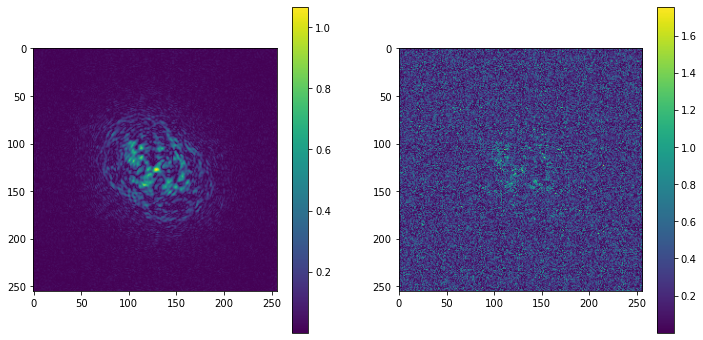

In [20]:
idx = 14
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
plt.imshow((np.abs(imgs[idx].reshape([nx, nx]))))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow((np.abs(imgs_noisy[idx].reshape([nx, nx]))))
plt.colorbar()

plt.rcParams["figure.figsize"] = 6, 6

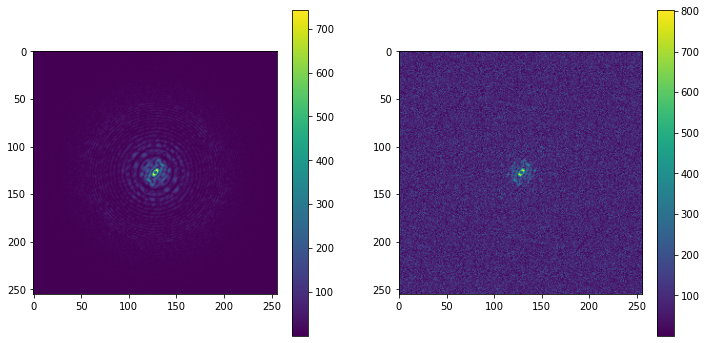

In [21]:
idx = 14
plt.rcParams["figure.figsize"] = 12, 6

plt.subplot(1, 2, 1)
plt.imshow(np.fft.fftshift(np.abs(imgs_f[idx].reshape([nx, nx]))))
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(np.fft.fftshift(np.abs(imgs_f_noisy[idx].reshape([nx, nx]))))
plt.colorbar()

plt.rcParams["figure.figsize"] = 6, 6